In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from keras import callbacks

2024-07-06 09:10:26.253071: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-06 09:10:26.253201: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-06 09:10:26.405060: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install skimpy
from skimpy import skim

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:
      Successfully uninstalled typing_extensions-4.9.0
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 16.1.0 which is incompatible.
jupyterlab 4.2.1 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is i

## Load Data

In [3]:
heart_df = pd.read_csv('/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv')
heart_df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
skim(heart_df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 303    │ │ int64       │ 13    │                                                          │
│ │ Number of columns │ 14     │ │ float64     │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name     ┃ NA   ┃ NA %   ┃ mean     ┃ sd       ┃ p0    ┃ p25     ┃ p50  ┃ p75     ┃ p100  ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━━━┩  │
│ │ age             │    0 │      0 │    54.37 │    9.082 │    29 │    47.5 │   55 │      61 │    77 │ ▁▃▅▇▅▁  │  │
│ │ sex             │    0 │      0 │   0.6832 │    0.466 │     0 │       0 │    1 │       1 │     1 │ ▃    ▇  │  │
│ │ cp              │    0 │      0 │    0.967 │    1.032 │     0 │       0 │    1 │       2 │     3 │ ▇ ▃ ▅▁  │  │
│ │ trtbps          │    0 │      0 │    131.6 │    17.54 │    94 │     120 │  130 │     140 │   200 │  ▃▇▇▃▁  │  │
│ │ chol            │    0 │      0 │    246.3 │    51.83 │   126 │     211 │  240 │   274.5 │   564 │   ▂▇▃   │  │
│ │ fbs             │    0 │      0 │   0.1485 │   0.3562 │     0 │       0 │    0 │       0 │     1 │ ▇    ▁  │  │
│ │ restecg         │    0 │      0 │   0.5281 │   0.5259 │     0 │       0 │    1 │       1 │     2 │  ▇  ▇   │  │
│ │ thalachh        │    0 │      0 │    149.6 │    22.91 │    71 │   133.5 │  153 │     166 │   202 │  ▂▃▇▇▁  │  │
│ │ exng            │    0 │      0 │   0.3267 │   0.4698 │     0 │       0 │    0 │       1 │     1 │ ▇    ▃  │  │
│ │ oldpeak         │    0 │      0 │     1.04 │    1.161 │     0 │       0 │  0.8 │     1.6 │   6.2 │  ▇▃▁▁   │  │
│ │ slp             │    0 │      0 │    1.399 │   0.6162 │     0 │       1 │    1 │       2 │     2 │ ▁  ▇ ▇  │  │
│ │ caa             │    0 │      0 │   0.7294 │    1.023 │     0 │       0 │    0 │       1 │     4 │  ▇▃ ▂▁  │  │
│ │ thall           │    0 │      0 │    2.314 │   0.6123 │     0 │       2 │    2 │       3 │     3 │   ▁ ▇▆  │  │
│ │ output          │    0 │      0 │   0.5446 │   0.4988 │     0 │       0 │    1 │       1 │     1 │ ▇    ▇  │  │
│ └─────────────────┴──────┴────────┴──────────┴──────────┴───────┴─────────┴──────┴─────────┴───────┴─────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [5]:
heart_df.duplicated().sum()

1

In [6]:
heart_df.drop_duplicates(inplace = True)

## Visualization of each variable.

<Axes: xlabel='output', ylabel='count'>

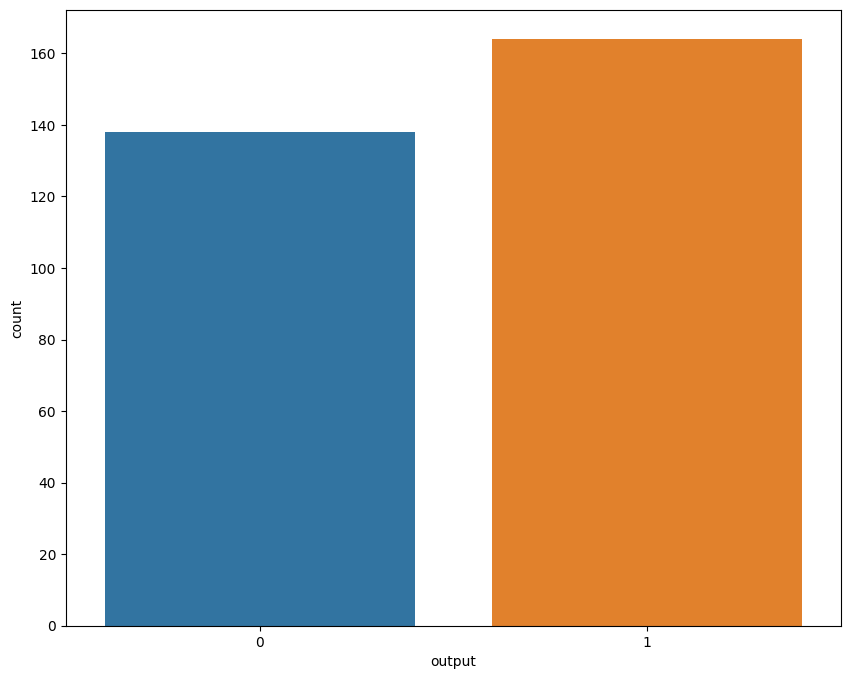

In [7]:
plt.figure(figsize=(10,8))
sns.countplot(x='output', data = heart_df)

In [8]:
heart_df.describe().style.background_gradient()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,54.420530,0.682119,0.963576,131.602649,246.500000,0.149007,0.526490,149.569536,0.327815,1.043046,1.397351,0.718543,2.314570,0.543046
std,9.047970,0.466426,1.032044,17.563394,51.753489,0.356686,0.526027,22.903527,0.470196,1.161452,0.616274,1.006748,0.613026,0.498970
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.250000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.500000,1.000000,1.000000,130.000000,240.500000,0.000000,1.000000,152.500000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.750000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [9]:
for col in heart_df.columns:
    if heart_df[col].value_counts().count() < 10:
        print(col)

sex
cp
fbs
restecg
exng
slp
caa
thall
output


In [10]:
categorical_variables = ['sex','cp','fbs','restecg','exng','slp',
                         'caa','thall','output']

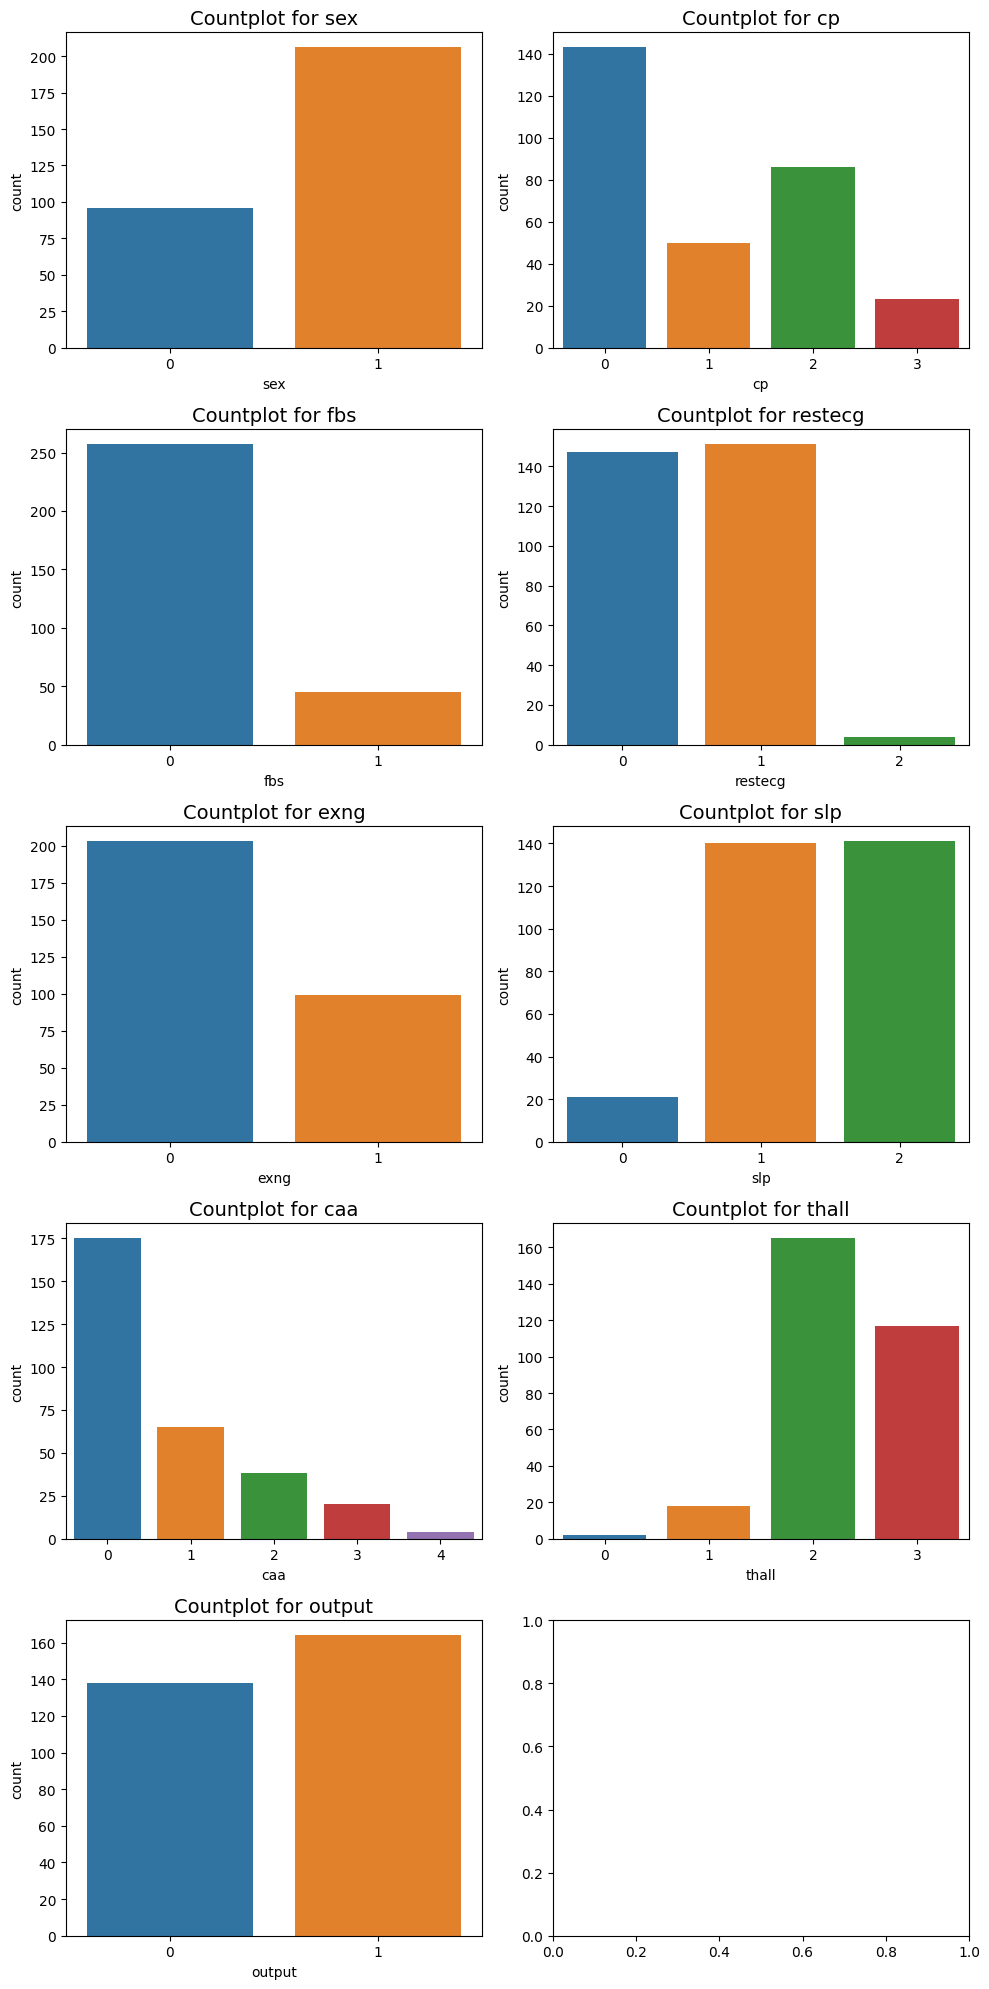

In [11]:
fig, axes = plt.subplots(ncols =2, nrows =5, figsize=(10,20))

for i, ax in enumerate(axes.flat):
    if i < len(categorical_variables):
        sns.countplot(data=heart_df, x=categorical_variables[i], ax=ax)
        ax.set_title(f'Countplot for {categorical_variables[i]}', fontsize=14)
        
plt.tight_layout()
plt.show()

In [12]:
num_variables = (heart_df.drop(columns = categorical_variables).columns).tolist()

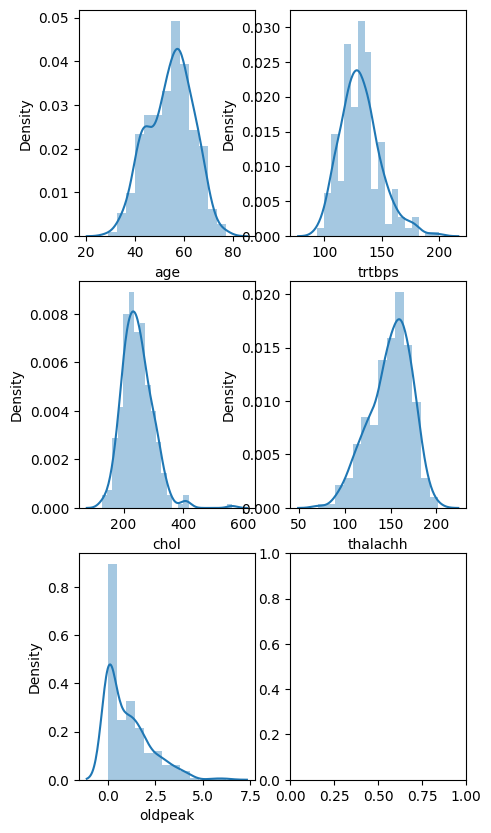

In [13]:
fig, axes = plt.subplots(ncols = 2, nrows =3, figsize=(5,10))

for i, ax in enumerate(axes.flat):
    if i <len(num_variables):
        sns.distplot(heart_df[num_variables[i]], ax=ax)

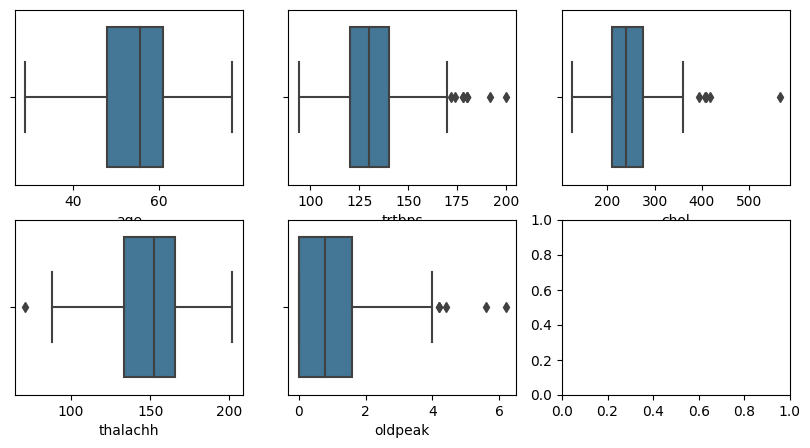

In [14]:
fig, axes = plt.subplots(2,3,figsize=(10,5))

for i, ax in enumerate(axes.flat):
    if i < len(num_variables):
        sns.boxplot(data = heart_df, x = num_variables[i],ax=ax, palette ='mako')

In [15]:
X = heart_df.drop(columns = ['output'])
Y = heart_df['output']

X_columns = X.columns.tolist()
stdscaler = StandardScaler()
X_scaled = stdscaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X_columns)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state =42)

In [16]:
X_train.shape

(241, 13)

In [17]:
X_test.shape

(61, 13)

In [18]:
Y_train.shape

(241,)

In [19]:
Y_test.shape

(61,)

In [20]:
early_stopping = callbacks.EarlyStopping(min_delta=0.001, patience =20, restore_best_weights=True)

seqmodel = Sequential()
seqmodel.add(Dense(units=16, kernel_initializer='uniform', activation='relu', input_dim=13))
seqmodel.add(Dense(units=8, kernel_initializer='uniform', activation='relu'))
seqmodel.add(Dropout(0.25))
seqmodel.add(Dense(units=4, kernel_initializer='uniform', activation='relu'))
seqmodel.add(Dropout(0.5))
seqmodel.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

from keras.optimizers import SGD

seqmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])


model_train = seqmodel.fit(X_train, Y_train, batch_size=32, epochs=500, callbacks=[early_stopping], validation_split=0.2)


Epoch 1/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.4987 - loss: 0.6933 - val_accuracy: 0.5714 - val_loss: 0.6931
Epoch 2/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5019 - loss: 0.6932 - val_accuracy: 0.5714 - val_loss: 0.6928
Epoch 3/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5297 - loss: 0.6929 - val_accuracy: 0.5714 - val_loss: 0.6925
Epoch 4/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5374 - loss: 0.6928 - val_accuracy: 0.5714 - val_loss: 0.6922
Epoch 5/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5381 - loss: 0.6925 - val_accuracy: 0.5714 - val_loss: 0.6920
Epoch 6/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5315 - loss: 0.6928 - val_accuracy: 0.5714 - val_loss: 0.6918
Epoch 7/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5223 - loss: 0.6925 - val_accuracy: 0.5714 - val_loss: 0.6915
Epoch 8/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5435 - loss: 0.6923 - val_accuracy: 0.5714 - val_loss: 0.6912

In [21]:
val_accuracy = np.mean(model_train.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy', val_accuracy*100))


val_accuracy: 76.29%


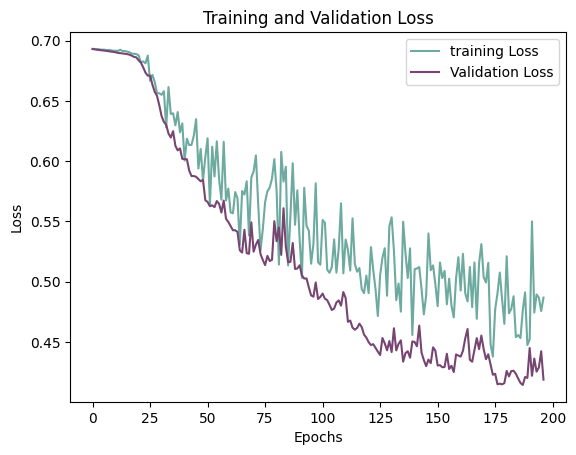

In [22]:
model_df = pd.DataFrame(model_train.history)

plt.plot(model_df.loc[:, ['loss']], '#6daa9f', label='training Loss')
plt.plot(model_df.loc[:, ['val_loss']], '#774571', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

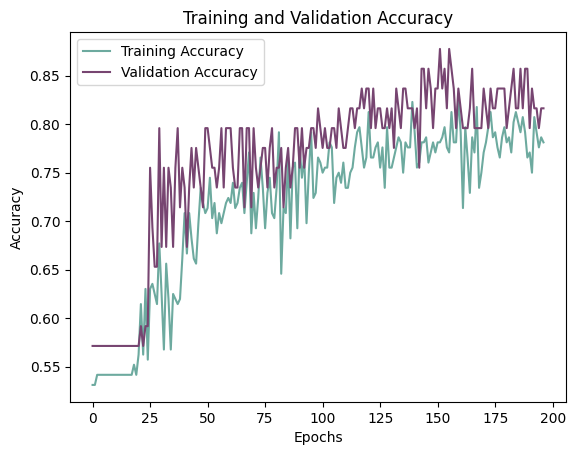

In [23]:
plt.plot(model_df.loc[:, ['accuracy']], '#6daa9f', label='Training Accuracy')
plt.plot(model_df.loc[:, ['val_accuracy']], '#774571', label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
Y_pred = seqmodel.predict(X_test)
Y_pred = (Y_pred > 0.5)
np.set_printoptions()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [25]:
Y_pred

array([[False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True]])

<Axes: >

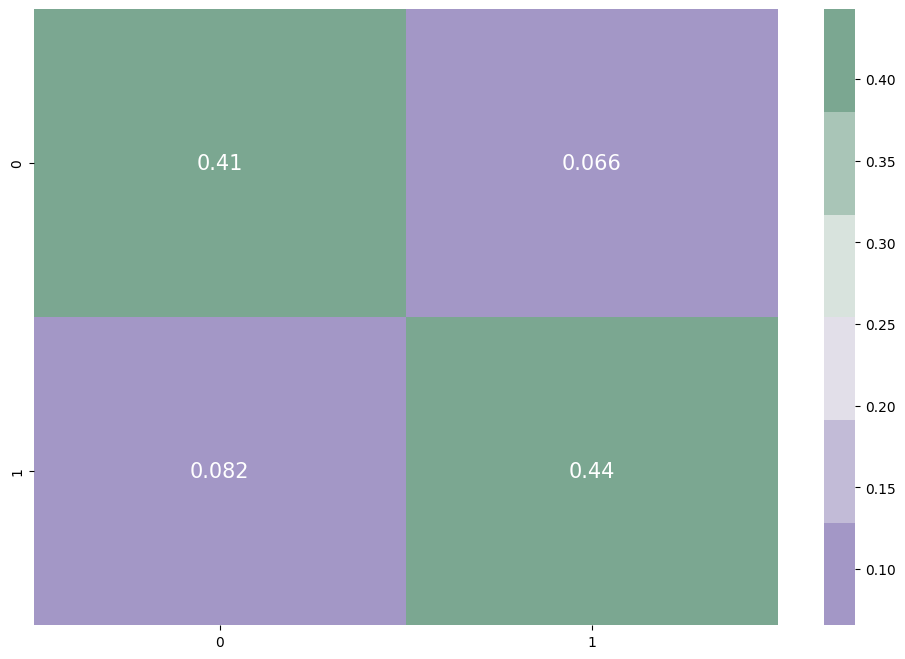

In [26]:
cmap1 = sns.diverging_palette(275, 150, s=40, l=65, n=6)
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap=cmap1, annot=True, annot_kws={'size':15})

In [27]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85        29
           1       0.87      0.84      0.86        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61

